<a href="https://colab.research.google.com/github/dinhquy-nguyen-1704/Mini_project/blob/main/Image_retrieval_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [ ]:
! pip install transformers==4.31.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

In [ ]:
dataset_dir = "image_retrieval_dataset/images_mr"
image_filename = os.listdir(dataset_dir)
src_images = []

for filename in image_filename:
    filepath = os.path.join(dataset_dir, filename)
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    src_images.append(image)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224").to(device)

In [ ]:
print(device)

cuda


In [ ]:
def preprocessing(images):
    inputs = processor(images, return_tensors='pt').to(device)

    with torch.no_grad():
        output = model(
                        **inputs,
                        output_hidden_states=True
                      ).hidden_states[-1][:, 0, :].detach().cpu().numpy()

    return output

In [ ]:
preprocessed_src_images = preprocessing(src_images)

In [ ]:
def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector/query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1)
    normalized_src = src_vectors/src_norms[:, np.newaxis]

    cosine_similarity = np.dot(normalized_src, normalized_query)

    return cosine_similarity

In [ ]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=5) :
    scores = cosine_similarity(preprocessed_query_image, preprocessed_src_images)
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]

    return ranked_list, scores

(1, 768)
Query Image


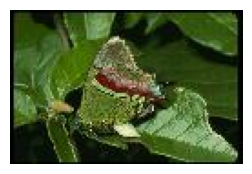

Top 5 results


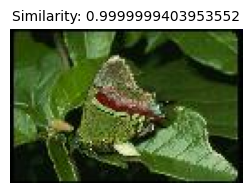

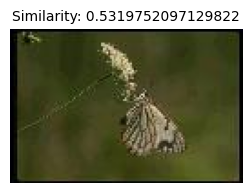

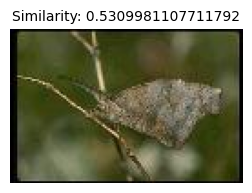

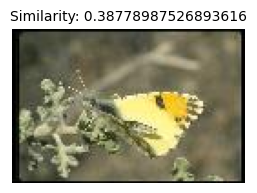

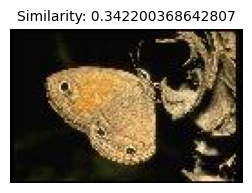

In [ ]:
query_image_paths = ['image_retrieval_dataset/images_mr/1.jpg']
top_k = 5

for query_image_path in query_image_paths:
    query_image = cv2.imread(query_image_path, 1)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    preprocessed_query_image = preprocessing(query_image).reshape(-1)

    ranked_list, scores = ranking(preprocessed_query_image, preprocessed_src_images, top_k)

    print('Query Image')
    plt.figure(figsize=(3, 3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()
    print(f'Top {top_k} results')

for idx in range(len(ranked_list)):
    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3, 3))
    plt.imshow(src_images[src_image_idx])
    plt.title(f'Similarity: {similarity_score}', fontsize=10)
    plt.axis('off')
    plt.show ()